## **量化投资分析：基于茅指数的均值回归策略**

### **1. 项目介绍**

本项目聚焦于中国A股市场的 "核心资产" 投资策略，通过构建和回测基于 "茅指数" 的均值回归模型，探索量化投资在龙头股组合中的应用。项目将实现数据获取与处理、策略回测、绩效评估和可视化展示的完整流程。本项目主要研究所选成分股在2025年上半年（2025.1.1-2025.6.30）期间的表现与投资策略，读者可在此基础上进行延伸探究。

> **茅指数：** 主要指在消费、医药、科技制造等领域具有较强成长性和技术实力的一些A股龙头企业。茅指数并不是一个标准的概念，不同机构统计的企业可能有所出入，但总体来说较为一致。以Wind中的茅指数（8841415.WI）为例，截至2025年8月4日，共包含37家公司。本项目选取以下10只代表性股票作为成分股。

|股票代码|英文简称|A股市值（亿元）|申万行业（2021）一级分类|
|:----:|:----:|:----:|:----:|
|600519.SH|KWEICHOW MOUTAI|17800.32|食品饮料|
|600036.SH|CMB|9163.38|银行|
|600900.SH|CYPC|6719.63|公用事业|
|600276.SH|HENGRUI PHARMA|3910.97|医药生物|
|600309.SH|WANHUA|1907.08|基础化工|
|600887.SH|YILI|1731.46|食品饮料|
|600690.SH|HAIER SMART HOME|1557.37|家用电器|
|600436.SH|ZZPZH|1210.98|医药生物|
|600585.SH|ACC|935.93|建筑材料|
|600763.SH|TC MEDICAL|206.29|医药生物|

数据来源：Wind，数据截至2025年8月3日

> **均值回归策略(Mean Reversion Strategy)：** 量化金融中的经典策略。该策略基于统计学原理，认为资产价格在偏离其历史均值后，最终会回归到平均水平。因此，通过识别这些偏离机会，可以在价格回归时获得收益。

### **2. 项目环境搭建**

Python虚拟环境，可以使用Anaconda或Python自带的venv工具进行搭建。

1. 克隆Git仓库
    
    ```bash
    git clone https://gitcode.com/yuxin_ye/algovault.git
    ```

2. 如果使用Conda创建虚拟环境，执行以下命令： 
    
    ```bash
    # Recreate environment from file
    conda env create -f environment.yml

    # Activate environment
    conda activate algovault

    # Verify installation (optional)
    conda list
    ```

3. 如果使用venv创建虚拟环境，执行以下命令： 
    
    ```bash
    # Create virtual environment
    python -m venv algovault

    # Activate environment
    source algovault/bin/activate

    # Install dependencies
    pip install -r requirements.txt

    # Verify installation (optional)
    pip list
    ```

4. **配置你的Tushare API密钥**
   
   ```bash
   export TUSHARE_API_KEY='你的Tushare API密钥'
   ```


### **3. 基于茅指数的均值回归策略**

**3.1 数据获取与处理**

本项目数据来源于Tushare金融数据平台（https://tushare.pro/ ），需要用户自行注册账户并获取一定积分后方可使用。如无法成功获取，本项目提供了选取的10只成分股2021.1.4-2021.4.30的部分数据供读者使用。

如何获取Tushare API Token：
1. 注册Tushare账号：https://tushare.pro/
2. 登录后在 "个人中心" 获取接口Token
3. 可以选择创建.env文件，在文件中写入你的Token：TUSHARE_API_KEY = "你的Token"；或者使用环境变量TUSHARE_API_KEY。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

# 设置Tushare API Token
import tushare as ts
import os
from dotenv import load_dotenv

load_dotenv()
TUSHARE_API_KEY = os.environ.get("TUSHARE_API_KEY")

读取10只成分股和沪深300的相关数据，本项目将会使用收盘价$closePrice$、流通市值$negMarketValue$、涨跌幅$chgPct$三个字段。

In [2]:
from algovault import init_tushare, get_stock_data, get_hs300_data, set_stock_mapping

# 股票代码与名称映射
STOCK_MAPPING = {
    '600519': 'KWEICHOW MOUTAI',
    '600036': 'CMB',
    '600900': 'CYPC', 
    '600276': 'HENGRUI PHARMA',
    '600309': 'WANHUA',
    '600887': 'YILI',
    '600690': 'HAIER SMART HOME',
    '600436': 'ZZPZH',
    '600585': 'ACC',
    '600763': 'TC MEDICAL'  
}

set_stock_mapping(STOCK_MAPPING)

# 参数设置
start_date = '20250101'
end_date = '20250630'
tickers = list(STOCK_MAPPING.keys())
        
# 初始化API
pro = init_tushare(TUSHARE_API_KEY)

# 获取数据
stock_data = get_stock_data(pro, STOCK_MAPPING, start_date, end_date)
hs300_data = get_hs300_data(pro, start_date, end_date)

Tushare API连接成功
成功获取 600519 (KWEICHOW MOUTAI) 数据
成功获取 600036 (CMB) 数据
成功获取 600900 (CYPC) 数据
成功获取 600276 (HENGRUI PHARMA) 数据
成功获取 600309 (WANHUA) 数据
成功获取 600887 (YILI) 数据
成功获取 600690 (HAIER SMART HOME) 数据
成功获取 600436 (ZZPZH) 数据
成功获取 600585 (ACC) 数据
成功获取 600763 (TC MEDICAL) 数据
成功获取HS300指数数据


**3.2 策略回测**

- **捏合自定义"茅指数"** \
以流通市值$negMarketValue$为权重捏合这10只股票，形成自定义的"茅指数"：\
假设$mktvalue_k^t$为第t天、第k只股票的流通市值；$r_k^t$为第t天、第k只股票的收益率（以涨跌幅$chgPct$表示）。
    - *第t天总市值：* $$total \_ mktvalue_t = \sum_{k=1}^{10} mktvalue_k^t$$ 
    - *第t天、第k只股票占茅指数的权重：* $$weight_k^t = \frac{mktvalue_k^t}{total \_ mktvalue_t}$$ 
    - *茅指数每日收益率：* $$mao\_ r_t = \sum_{k=1}^{10} weight_k^t \times r_k^t$$

- **均值回归策略回测** \
计算当日个股收盘价的5日均值：$\text{MA5}$； \
计算当日个股收盘价到5日均值的偏离程度：$ratio = (closePrice-\text{MA5})/\text{MA5}$； \
根据当日所有个股的$ratio$，挑出$ratio$为负的个股，第二天等权持仓； \
\**解释：$ratio$为负时，说明当前个股价格低于$\text{MA5}$，具有回归均值的趋势，价格上涨的可能越大*\
根据每日的持仓个股和个股收益率，计算每日的策略收益率； \
根据策略、茅指数和沪深300（作为市场基准）的每日收益率，分别计算每日净值，便于后续进行绩效评估； \
为方便检查，分别输出策略、茅指数和沪深300最后一天的净值。

    $PS$：
    1. 在计算5日均值时，前4日会产生Nan，当$ratio$为Nan值时，默认持有该股票； 
    2. 由于我们用当天数据预测第二天持仓，所以我们规定首个交易日（2025/1/1）等权持有10只股票。 

    > *净值计算公式：* 其中$r_i$为第i天的收益率，$Nav_t$为第t天的净值 $$Nav_t = \prod_{i=1}^{t} (1+r_i)$$ 

In [3]:
from algovault import calculate_mao_index, mean_reversion_strategy

# 计算茅指数收益率
mao_returns = calculate_mao_index(stock_data)
    
# 运行策略
strategy_nav, mao_nav, hs300_nav, positions, returns = mean_reversion_strategy(
    stock_data, mao_returns, hs300_data
)

# 输出最后一天净值以检查策略运行情况
print("最后一天净值：")
print(f"均值回归策略净值：{strategy_nav.iloc[-1]:.2f}")
print(f"茅指数净值：{mao_nav.iloc[-1]:.2f}")
print(f"沪深300净值：{hs300_nav.iloc[-1]:.2f}")

最后一天净值：
均值回归策略净值：1.10
茅指数净值：1.02
沪深300净值：1.00


**3.3 绩效评估**

以下使用累计收益率、年化收益率、最大回撤、夏普比率、卡玛比率等作为评估策略回测结果的主要指标。假设一年交易日为252天。
- *累计收益率：* $$\text{Cumulative Return} = \left(\frac{\text{Final Value}}{\text{Initial Value}} - 1\right) \times 100 \% $$
- *年化收益率：* $$\text{Annualized Return} = \left(1 + \text{Cumulative Return}\right)^{\frac{252}{\text{Days}}} - 1 $$
- *最大回撤：* $$\text{Drawdown}_t = \frac{\text{Nav}_t}{\max(\text{Nav}_1, \text{Nav}_2, ..., \text{Nav}_t)} - 1$$ $$\text{Max Drawdown} = \min(\text{Drawdown}_t) \times 100 \% $$
- *夏普比率：* \
其中，假设年无风险利率$r_f = 1 \%$，$R_f$为日无风险利率，$R_p$为每日收益率，$\sigma_{(R_p - R_f)}$为收益波动率标准差 $$R_f = (1 + r_f)^{\frac{1}{252}} - 1$$ $$\text{Sharpe Ratio} = \sqrt{252} \times \frac{E[R_p - R_f]}{\sigma_{(R_p - R_f)}}$$
- *卡玛比率：* $$\text{Calmar Ratio} = \frac{\text{Annualized Return}}{|\text{Max Drawdown}|}$$

In [4]:
from algovault import evaluate_strategy

# 评估策略
performance = evaluate_strategy(strategy_nav, mao_nav, hs300_nav)

==== 策略绩效评估 ====
累计收益率: 策略 10.16% | 茅指数 1.66% | HS300 0.03%
年化收益率: 策略 23.17% | 茅指数 3.60% | HS300 0.06%
最大回撤: 策略 -7.19% | 茅指数 -6.70% | HS300 -10.49%
夏普比率: 策略 1.36 | 茅指数 0.35 | HS300 0.43
卡玛比率: 策略 3.22 | 茅指数 0.54 | HS300 0.01


除以上常见的投资组合评估指标外，在实际投资场景中，还会使用达标率（评估策略是否稳定达标）、胜率（常用于高频交易、短线策略评估）等其他指标，读者可根据实际需求进行选择。

In [5]:
from algovault import calculate_probability, rolling_win_rate

Date = mao_returns.index
df = pd.DataFrame(strategy_nav, index=Date, columns=['nav']).dropna()

TARGET = 0.1  # 目标收益率10%
month = 3 # 持有期3个月

# 计算达标概率
probability = calculate_probability(df, TARGET, month)
print(f"累计收益率达标概率：{probability:.2%}")

# 计算3个月持有期胜率（假设252个交易日）
win_rate = rolling_win_rate(df, holding_period=month*21)
print(f'滚动持有3个月正收益概率：{win_rate:.2%}')

累计收益率达标概率：63.16%
滚动持有3个月正收益概率：85.19%


**3.4 可视化展示**

以下通过三个维度的图表来全面展示策略效果：
- *净值曲线对比图：* 对比策略与基准指数（茅指数、沪深300）的收益曲线，并比较不同策略在整个回测期间的收益情况。
- *持仓状态变化图：* 通过子图形式展示策略中每只成分股的持仓状态变化，每个子图对应一只股票，以时间轴为横轴，持仓状态为纵轴（股票持有期间持仓状态为1，不持有为0），帮助分析策略的调仓频率和持仓集中度。
- *价格与技术指标图：* 选取部分代表性股票，绘制其收盘价与5日移动平均线（MA5）的对比图。当股票价格低于MA5时（ratio < 0），策略会在下一个交易日买入该股票，通过高亮区域标记股票持有期。

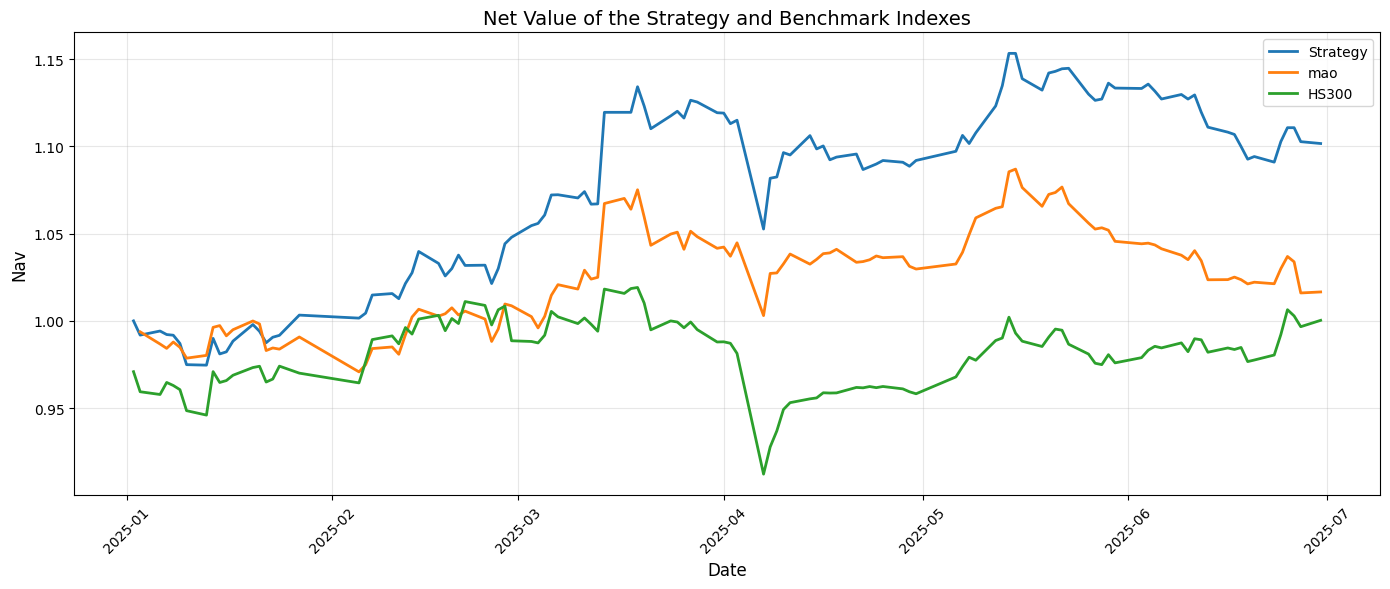

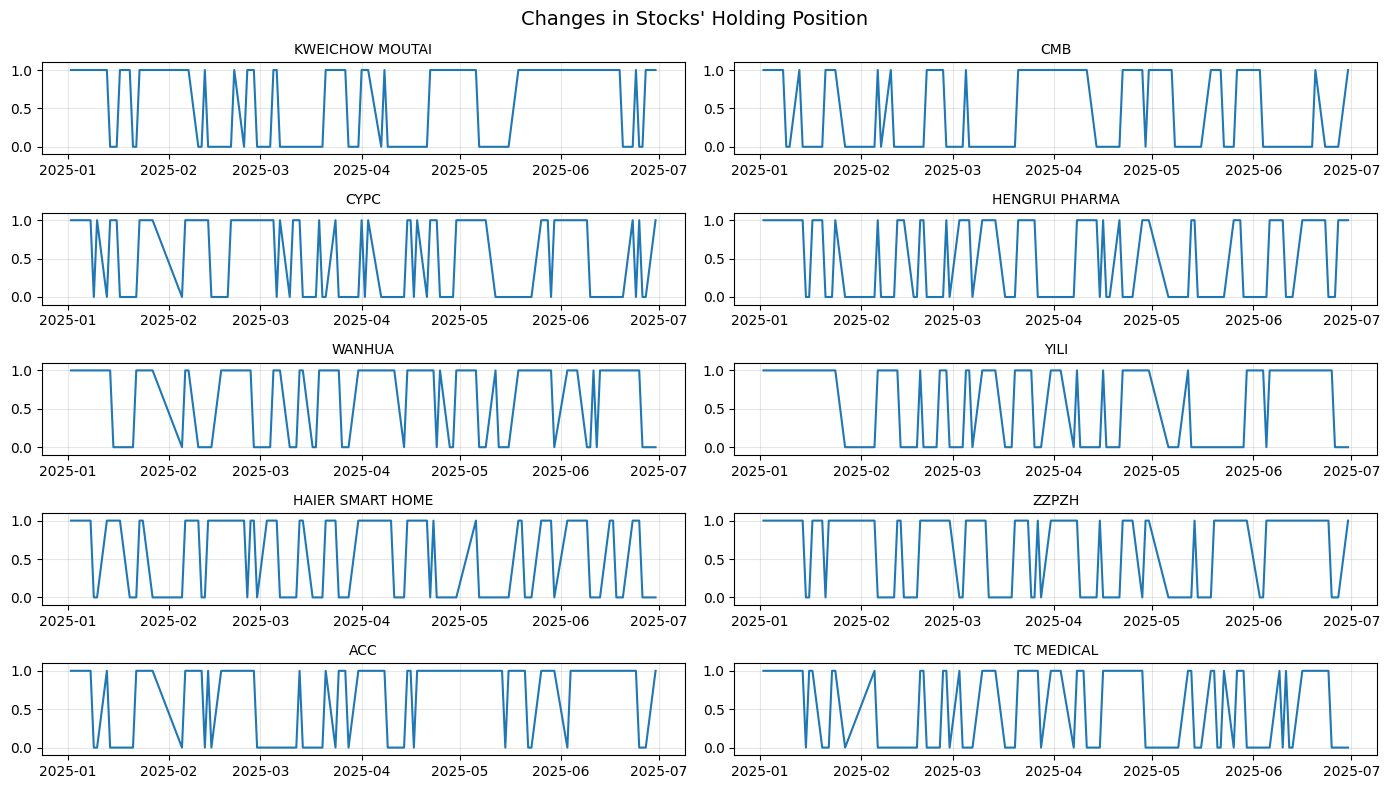

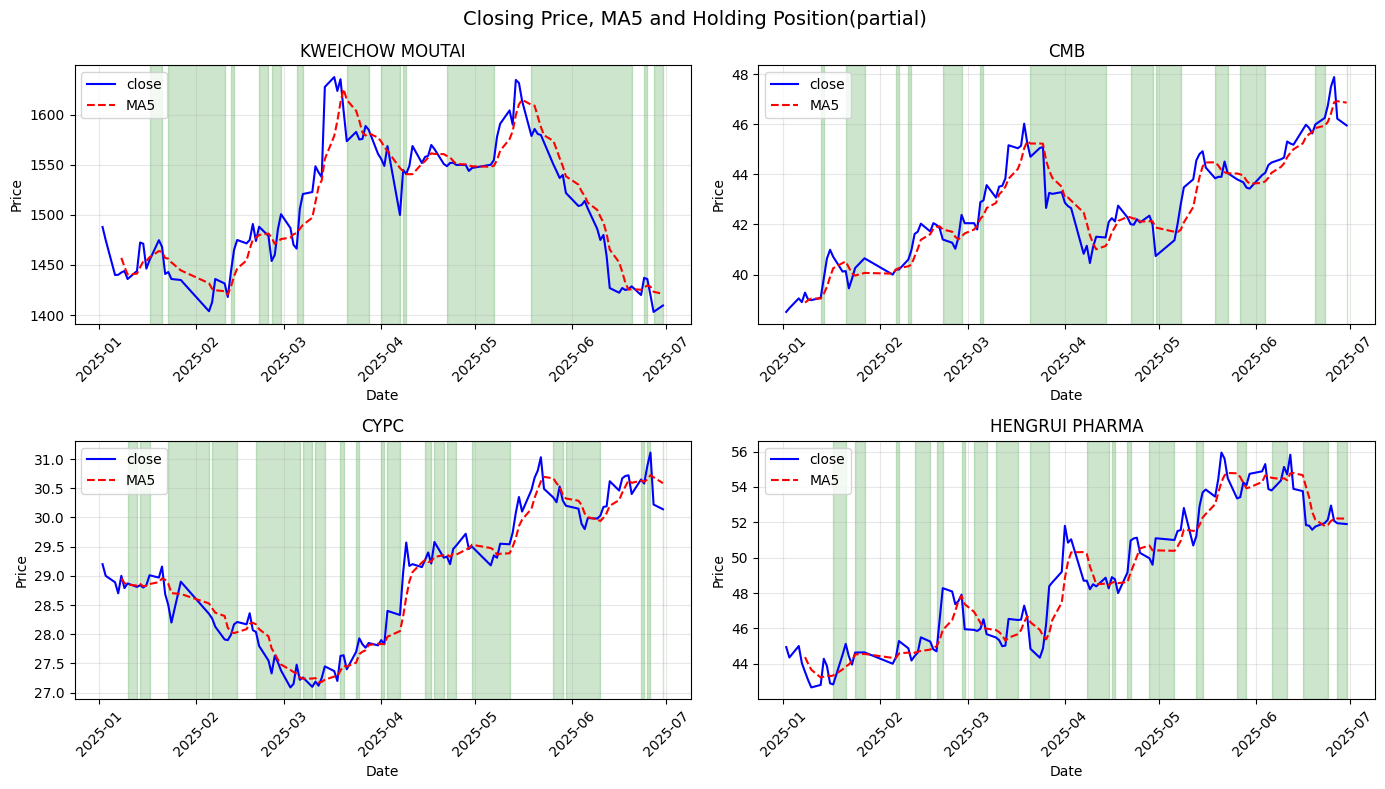

In [6]:
from algovault import visualize_results

# 可视化结果
visualize_results(strategy_nav, mao_nav, hs300_nav, positions, stock_data, language='Eng') # 图片显示设置为英文避免出现中文乱码问题

### **4. 如何在InsCodeAI中运行项目**

本项目支持在CSDN旗下的InsCodeAI云平台中运行，即读者可直接在浏览器中进行运行调试，无需安装。为避免InsCodeAI中的中文字体显示问题，读者可使用已将可视化中文部分转换为英文的Quantitative_analysis_inscode.ipynb文件进行复现。此外，由于InsCodeAI并未直接提供Jupyter Notebook模板，读者需要根据以下步骤通过命令行自行部署Jupyter Notebook。

1. **创建Python项目** \
   在InsCodeAI中新建一个项目，该项目会自动同步到GitCode，实现一键托管和版本管理。\
   在InsCodeAI首页点击"我的项目"-"创建项目"-"从Git导入"-"其他"，输入以下仓库地址：
   ```bash
   https://gitcode.com/yuxin_ye/algovault.git
   ```
   语言环境选择Python，版本选择python3.11，点击"导入项目"。
   
2. **安装依赖** \
   打开终端，执行以下命令安装必要的依赖包：
   ```bash
   pip install -r requirements.txt
   ```
   
3. **配置Jupyter Notebook** \
   为了便于访问，可以创建一个自定义配置文件jupyter_notebook_config.py：
   ```bash
   c.NotebookApp.disable_check_xsrf = True
   c.NotebookApp.token = ''
   c.NotebookApp.password = ''
   # 出于安全考虑，在生产环境中请勿禁用身份验证
   ```

4. **启动Jupyter Notebook** \
   运行以下命令启动服务：
   ```bash
   jupyter notebook --ip=0.0.0.0 --port=8888 --no-browser --allow-root --config=./jupyter_notebook_config.py
   ```
   启动成功后，就可以通过浏览器访问Jupyter Notebook环境了。

### **5. 总结**

本项目通过构建和回测基于"茅指数"的均值回归策略，对A股市场的"核心资产"进行了全面的量化投资分析，完整展示其分析全流程，包括数据获取与处理、策略构建与回测、绩效评估和可视化展示。通过使用流通市值加权构建的"茅指数"作为基准，结合基于5日均线的均值回归交易信号，成功开发出一套适用于中国龙头股的投资策略。

结果显示，均值回归策略在测试期间显著跑赢茅指数和沪深300基准指数，累计收益率达到10.16%，而茅指数和沪深300分别为1.66%和0.03%。策略的年化收益率为23.17%，夏普比率高达1.36，卡玛比率为3.22，表明该策略在获得高收益的同时具有良好的风险调整表现，同时也说明利用均值回归原理的量化策略在交易中国核心资产方面是有效的，这为寻求系统性方法在A股市场获取超额收益的投资者提供了参考。

该项目展示了如何将数据驱动的量化方法应用于识别和利用市场非有效性，为新兴市场的量化分析和策略开发提供了一个可复制框架，具有良好的实践指导意义。